# 고양이 얼굴 검출(탐지)

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [85]:
#!gdown https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb

In [86]:
#!unzip /content/BBRegression.zip

# 데이터 준비

In [87]:
import glob
import xml.etree.ElementTree as ET

# 함수 가져오기 

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [88]:
IMAGE_PATH = '/content/BBRegression'

In [89]:
import os

FILE_NAME = 'label_cats.csv'
csv_path = os.path.join(IMAGE_PATH, 'train')
xml_df = xml_to_csv(csv_path)
xml_df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-2_jpg.rf.6b1b1624fe8ccd6c05c7d9b1935bb304.jpg,224,224,cat,36,9,159,123
1,cat-210_jpg.rf.d0f3c57f2d93b75a913b8ca95fe351b...,224,224,cat,20,8,206,190
2,cat-212_jpg.rf.6410693af68b7e92e7d9b6cece7538b...,224,224,cat,18,3,187,210
3,cat-227_jpg.rf.b0e39e49b4f074a8b151a2d130a1390...,224,224,cat,34,11,142,120
4,cat-111_jpg.rf.3a2689de6862347f22c8e43b13b0710...,224,224,cat,35,37,173,152
5,cat-203_jpg.rf.1b9ff57230f89394265dc7e887be9fe...,224,224,cat,41,2,162,146
6,cat-242_jpg.rf.3d72105461277a14e06d26fbdda59fd...,224,224,cat,66,4,135,114
7,cat-137_jpg.rf.d864c50410a6ef5efcff10ab1036673...,224,224,cat,52,142,156,224
8,cat-278_jpg.rf.74711a921511b775e883f558f612378...,224,224,cat,28,32,100,130
9,cat-129_jpg.rf.ee034fc60c0a11e7e920f17cb80f0cd...,224,224,cat,73,2,152,102


In [90]:
xml_df.to_csv(FILE_NAME)

In [91]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  91 non-null     object
 1   width     91 non-null     int64 
 2   height    91 non-null     int64 
 3   class     91 non-null     object
 4   xmin      91 non-null     int64 
 5   ymin      91 non-null     int64 
 6   xmax      91 non-null     int64 
 7   ymax      91 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 5.8+ KB


In [92]:
images = xml_df.iloc[:,0].values
images[:5]

array(['cat-2_jpg.rf.6b1b1624fe8ccd6c05c7d9b1935bb304.jpg',
       'cat-210_jpg.rf.d0f3c57f2d93b75a913b8ca95fe351b9.jpg',
       'cat-212_jpg.rf.6410693af68b7e92e7d9b6cece7538b2.jpg',
       'cat-227_jpg.rf.b0e39e49b4f074a8b151a2d130a13903.jpg',
       'cat-111_jpg.rf.3a2689de6862347f22c8e43b13b07102.jpg'],
      dtype=object)

In [93]:
points = xml_df.iloc[:,4:].values
points[:4]

array([[ 36,   9, 159, 123],
       [ 20,   8, 206, 190],
       [ 18,   3, 187, 210],
       [ 34,  11, 142, 120]])

# 시각화

In [94]:
import PIL

dataset_images = []
dataset_bbs = []

for file, point in zip (images, points):
  f = os.path.join(IMAGE_PATH, 'train', file)
  image = PIL.Image.open(f)
  arr = np.array(image)
  dataset_images.append(arr)
  dataset_bbs.append(point)

dataset_images = np.array(dataset_images)
dataset_bbs = np.array(dataset_bbs)

In [95]:
print(dataset_images.shape, dataset_bbs.shape)

(91, 224, 224, 3) (91, 4)


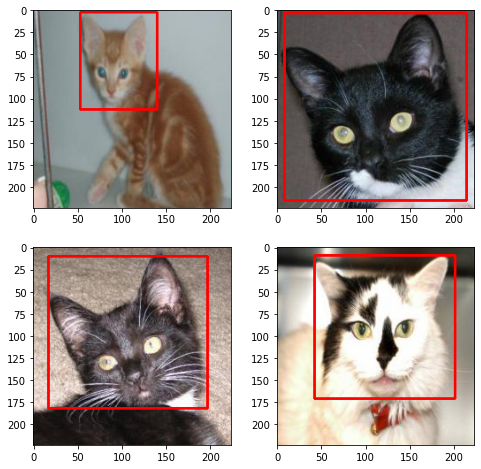

In [96]:
import cv2

samples = np.random.randint(91, size=4)

plt.figure(figsize = (8,8))
for i, idx in enumerate(samples):
  points = dataset_bbs[idx].reshape(2,2)
  img = cv2.rectangle(dataset_images[idx].copy(),
                      tuple(points[0]),
                      tuple(points[1]),
                      color=(255, 0, 0),
                      thickness=2)
  
  plt.subplot(2, 2, i+1)
  plt.imshow(img)
plt.show()



In [97]:
np.savez('cat_bbs.npz', 
         image=dataset_images,
         bbs=dataset_bbs
         )

In [98]:
dataset=np.load('cat_bbs.npz',)

x = dataset['image']
y = dataset['bbs']

x.shape, y.shape

((91, 224, 224, 3), (91, 4))

# 검증데이터

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

x_train.shape, x_val.shape

((72, 224, 224, 3), (19, 224, 224, 3))

# 정규화

In [100]:
x_train = x_train.astype('float32')/255.
x_val = x_val.astype('float32')/255.

In [101]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

y_train.dtype

dtype('float32')

# 모델

In [105]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(input_shape = (224, 224, 3),
                   include_top=False,
                   weights='imagenet')
base.trainable=False

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(4),
])

model.compile(
    optimizer='adam',
    loss='mse', # 2진 분류 binary 다중 분류 categorical 회귀 mse(mean squared error)
    metrics=['acc']
)

In [106]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
_____________________________________

In [114]:
ckpt_path = '/ckpt/cats_bbs.ckpt'

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_onlt=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

In [115]:
EPOCHS = 30
BATCH_SIZE = 16

log = model.fit(
    x_train, y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data=(x_val,y_val),
    callbacks = [ckpt_cb],
    verbose = 1
)

Epoch 1/30
3/5 [=================>............] - ETA: 0s - loss: 2272.9482 - acc: 0.7708
Epoch 1: val_loss improved from inf to 1244.93750, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 1895.0658 - acc: 0.7500 - val_loss: 1244.9375 - val_acc: 0.7368
Epoch 2/30
3/5 [=================>............] - ETA: 0s - loss: 914.6892 - acc: 0.7917
Epoch 2: val_loss improved from 1244.93750 to 779.32220, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 771.8818 - acc: 0.8333 - val_loss: 779.3222 - val_acc: 0.6316
Epoch 3/30
3/5 [=================>............] - ETA: 0s - loss: 451.0464 - acc: 0.8750
Epoch 3: val_loss did not improve from 779.32220
5/5 [==============================] - 0s 42ms/step - loss: 444.4142 - acc: 0.8472 - val_loss: 804.0903 - val_acc: 0.8947
Epoch 4/30
4/5 [=======================>......] - ETA: 0s - loss: 309.0211 - acc: 0.8594
Epoch 4: val_loss improved from 779.32220 to 667.01959, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 305.2479 - acc: 0.8472 - val_loss: 667.0196 - val_acc: 0.7895
Epoch 5/30
3/5 [=================>............] - ETA: 0s - loss: 169.5870 - acc: 0.8333
Epoch 5: val_loss improved from 667.01959 to 604.94434, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 175.3108 - acc: 0.8472 - val_loss: 604.9443 - val_acc: 0.6316
Epoch 6/30
3/5 [=================>............] - ETA: 0s - loss: 133.8556 - acc: 0.8958
Epoch 6: val_loss did not improve from 604.94434
5/5 [==============================] - 0s 41ms/step - loss: 114.2990 - acc: 0.8889 - val_loss: 619.5461 - val_acc: 0.8947
Epoch 7/30
3/5 [=================>............] - ETA: 0s - loss: 61.9717 - acc: 0.9583
Epoch 7: val_loss did not improve from 604.94434
5/5 [==============================] - 0s 37ms/step - loss: 65.7313 - acc: 0.9028 - val_loss: 650.7601 - val_acc: 0.8421
Epoch 8/30
3/5 [=================>............] - ETA: 0s - loss: 48.2466 - acc: 0.9375
Epoch 8: val_loss improved from 604.94434 to 590.03052, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 42.9406 - acc: 0.9583 - val_loss: 590.0305 - val_acc: 0.8421
Epoch 9/30
3/5 [=================>............] - ETA: 0s - loss: 32.8651 - acc: 0.9583
Epoch 9: val_loss improved from 590.03052 to 582.75116, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 31.3597 - acc: 0.9583 - val_loss: 582.7512 - val_acc: 0.8947
Epoch 10/30
3/5 [=================>............] - ETA: 0s - loss: 16.9271 - acc: 0.9792
Epoch 10: val_loss did not improve from 582.75116
5/5 [==============================] - 0s 41ms/step - loss: 17.5020 - acc: 0.9861 - val_loss: 607.6744 - val_acc: 0.8947
Epoch 11/30
3/5 [=================>............] - ETA: 0s - loss: 12.0191 - acc: 0.9792
Epoch 11: val_loss improved from 582.75116 to 578.94653, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 10.7673 - acc: 0.9861 - val_loss: 578.9465 - val_acc: 0.8947
Epoch 12/30
5/5 [==============================] - ETA: 0s - loss: 7.9660 - acc: 0.9861
Epoch 12: val_loss did not improve from 578.94653
5/5 [==============================] - 0s 41ms/step - loss: 7.9660 - acc: 0.9861 - val_loss: 582.0101 - val_acc: 0.9474
Epoch 13/30
3/5 [=================>............] - ETA: 0s - loss: 3.9969 - acc: 1.0000
Epoch 13: val_loss improved from 578.94653 to 578.64764, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 4.3618 - acc: 0.9861 - val_loss: 578.6476 - val_acc: 0.9474
Epoch 14/30
3/5 [=================>............] - ETA: 0s - loss: 3.1790 - acc: 0.9792
Epoch 14: val_loss did not improve from 578.64764
5/5 [==============================] - 0s 41ms/step - loss: 2.9232 - acc: 0.9861 - val_loss: 586.0409 - val_acc: 0.8947
Epoch 15/30
3/5 [=================>............] - ETA: 0s - loss: 2.6939 - acc: 0.9792
Epoch 15: val_loss improved from 578.64764 to 577.31036, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 17s 4s/step - loss: 2.5628 - acc: 0.9861 - val_loss: 577.3104 - val_acc: 0.9474
Epoch 16/30
3/5 [=================>............] - ETA: 0s - loss: 1.5719 - acc: 1.0000
Epoch 16: val_loss did not improve from 577.31036
5/5 [==============================] - 0s 40ms/step - loss: 1.8446 - acc: 0.9861 - val_loss: 580.3381 - val_acc: 0.9474
Epoch 17/30
3/5 [=================>............] - ETA: 0s - loss: 1.1570 - acc: 0.9792
Epoch 17: val_loss improved from 577.31036 to 575.78748, saving model to /ckpt/cats_bbs.ckpt


5/5 [==============================] - 18s 4s/step - loss: 1.2002 - acc: 0.9861 - val_loss: 575.7875 - val_acc: 0.8947
Epoch 18/30
3/5 [=================>............] - ETA: 0s - loss: 1.4235 - acc: 1.0000
Epoch 18: val_loss did not improve from 575.78748
5/5 [==============================] - 0s 42ms/step - loss: 1.3631 - acc: 1.0000 - val_loss: 587.8963 - val_acc: 0.9474
Epoch 19/30
4/5 [=======================>......] - ETA: 0s - loss: 0.8849 - acc: 0.9844
Epoch 19: val_loss did not improve from 575.78748
5/5 [==============================] - 0s 36ms/step - loss: 0.8598 - acc: 0.9861 - val_loss: 576.2731 - val_acc: 0.8947
Epoch 20/30
4/5 [=======================>......] - ETA: 0s - loss: 0.8007 - acc: 0.9844
Epoch 20: val_loss did not improve from 575.78748
5/5 [==============================] - 0s 33ms/step - loss: 0.7774 - acc: 0.9861 - val_loss: 581.4745 - val_acc: 0.9474
Epoch 21/30
4/5 [=======================>......] - ETA: 0s - loss: 0.8219 - acc: 0.9844
Epoch 21: val_loss 

# 모델저장

In [116]:
# 1. keras 형태

model.save('cats_bbs_regression.h5')

In [118]:
my_model = tf.keras.models.load_model('cats_bbs_regression.h5')
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
_____________________________________

In [127]:
model.save('my_cats_model')
your_model = tf.keras.models.load_model('my_cats_model')
your_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
_____________________________________

# 테스트
- 테스트 이미지 로딩
- 예측

In [128]:
import os
FILE_NAME = 'label_cats.csv'

csv_path = os.path.join(IMAGE_PATH, 'test')

In [129]:
fnames = glob.glob('/content/BBRegression/test' + '/*.jpg')

for f in fnames:
  print(f)

/content/BBRegression/test/cat-268_jpg.rf.942ee4c485010ed238a09f80680dc0bc.jpg
/content/BBRegression/test/cat-144_jpg.rf.50b4b01d0df37d977b1341837708aa1d.jpg
/content/BBRegression/test/cat-273_jpg.rf.af452afbb9bb8767d534653a290090c2.jpg
/content/BBRegression/test/cat-110_jpg.rf.919d96206faca75068ac5595928f4005.jpg
/content/BBRegression/test/cat-243_jpg.rf.1da8871668b6d7bbe4a3d5aa11fd046e.jpg
/content/BBRegression/test/cat-249_jpg.rf.eba7bf7e8fe79642e84fdc3abc72e6f2.jpg
/content/BBRegression/test/cat-188_jpg.rf.4bb417309154766edeac39c9c9d083f7.jpg
/content/BBRegression/test/cat-255_jpg.rf.750c02515a1b2d898cceae6abf426452.jpg
/content/BBRegression/test/cat-123_jpg.rf.9a0878d7d6e110b302293109a66b43bf.jpg
/content/BBRegression/test/cat-143_jpg.rf.61045dbe235b78c5fdf8d2267b0bea85.jpg
/content/BBRegression/test/cat-207_jpg.rf.9634274bd68e49fcd575d53e83e72cae.jpg


In [130]:
import PIL

X_test = []

for f in fnames:
    image = PIL.Image.open(f)
    arr = np.array(image)
    X_test.append(arr)

X_test = np.array(X_test)                                                     

In [131]:
X_test = X_test.astype('float32')/255
y_pred = model.predict(X_test)
y_pred[:5]

1/1 [==============================] - 1s 1s/step


array([[ 3.52680283e+01, -8.55972990e-02,  1.67442566e+02,
         1.30058945e+02],
       [ 6.55100479e+01,  1.23372002e+01,  2.05489151e+02,
         1.74836288e+02],
       [ 4.46541634e+01,  1.39744558e+01,  1.61766968e+02,
         1.65193085e+02],
       [ 7.33341827e+01,  2.57071829e+00,  1.85566833e+02,
         1.11200348e+02],
       [ 4.38554649e+01,  1.18547945e+01,  1.79317032e+02,
         1.52779175e+02]], dtype=float32)

In [132]:
y_pred = y_pred.astype('int')

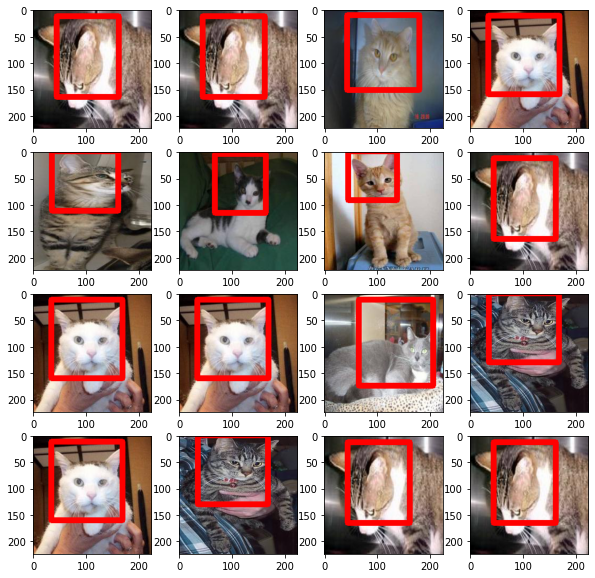

In [138]:
import cv2 as cv
samples = np.random.randint(X_test.shape[0], size=16)

plt.figure(figsize = [10,10])
for i, idx in enumerate(samples):
    points = y_pred[idx].reshape(2,2)

    img = cv.rectangle(X_test[idx].copy(),
                       tuple(points[0]),
                       tuple(points[1]),
                       color = (255,0,0),
                       thickness=10
    )
    plt.subplot(4,4,i+1)
    plt.imshow(img)
plt.show()